# Data Block API from the Foundations

#### Last Time
Most recently, in the [first notebook](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/07a_lsuv_my_reimplementation.ipynb?flush_cache=true) covered during week 11, we implemented layer-sequential unit-variance weight initialization. We found that initializing layer weights with LSUV enabled our CNN to begin to learn to classify [MNIST](http://yann.lecun.com/exdb/mnist/) digits far earlier than a similar CNN that had been initialized using Kaiming uniform.

#### Implementing fastai's Data Block API from scratch
In this notebook we create our own reimplementation of the fastai library's [Data Block API](https://docs.fast.ai/data_block.html). Back in [notebook 4](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/04_callbacks_my_reimplementation.ipynb?flush_cache=true) we implemented the `DataBunch` class, which gave us a simple, coordinated way to manage training and validation dataloaders.

Unfortunately, we had to complete several manual steps in order to get our data ready to be stored inside a DataBunch. We had to ensure that we first:
1. Collect the file paths to each image in the dataset.
2. Apply any necessary preprocessing transforms, such as converting images to RGB format.
3. Split the data into a training and validation sets.
4. Create numerical labels and run any other processors.
5. Ensure the inputs can be returned by dataloaders as members of mini-batches.

Furthermore, there are two additional steps we haven't covered yet, but will eventually need to include in our preprocessing pipeline:
1. Including data augmentation transforms.
2. Adding a test set that has no labels.

The fastai library's Data Block API was created to give practitioners a syntactically concise way to specify each of the above operations, chain one to the next, and execute all if them inside just one notebook cell. Below we'll examine how to implement each of the components that make this kind of API possible.

#### Attribution
Virtually all the code that appears in this notebook is the creation of [Sylvain Gugger](https://www.fast.ai/about/#sylvain) and [Jeremy Howard](https://www.fast.ai/about/#jeremy), with the exception of a couple of convenience methods I added that [let us chain together](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/08_data_block_my_reimplementation.ipynb?flush_cache=true#Executing-the-Data-Block) all the operations of our datablock implemention here. The original version of this notebook that Sylvain and Jeremy made for the course lecture can be found [here](https://github.com/fastai/course-v3/blob/master/nbs/dl2/08_data_block.ipynb). I simply re-typed, line-by-line, the pieces of logic necessary to implement the functionality that their notebook demonstrated. In some cases I changed the order of code cells and or variable names so as to fit an organization and style that seemed more intuitive to me. Any and all mistakes are my own.

On the other hand, all long-form text explanations in this notebook are solely my own creation. Writing extensive descriptions of the concepts and code in plain and simple English forces me to make sure that I actually understand how they work.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
#export
from exports.nb_07a import *

### 1. Storing image paths in an `ItemList`

We've had things somewhat easy with our [MNIST](http://yann.lecun.com/exdb/mnist/) experiments so far -- the dataset is small enough in size such that we can load it as a pickle file into our machine's RAM, all at once. Not all datasets are this compact, and often the only feasible approach is to load images from the disk into RAM mini-batch by mini-batch.

To illustrate how this works, and to make our experiments a bit more interesting, starting from this notebook we will use the [Imagenette dataset](https://github.com/fastai/imagenette/blob/master/README.md). Curated by [Jeremy Howard](https://github.com/jph00), Imagenette was conceived as a way to simulate training on [ImageNet](http://www.image-net.org/), without having to download and store the entire ImageNet dataset on your machine or compute instance, not to mention waiting the the several hours/days for your model to finish training.

Imagenette is simply a subset of ImageNet containing 10 easily classifiable classes: 
1. Tench (a fish)
2. English Springer (a dog)
3. Cassette Player 
4. Chain Saw 
5. Church 
6. French Horn 
7. Garbage Truck
8. Gas Pump 
9. Golf Ball
10. Parachute

We'll see that the beauty of Imagenette is that it allows us to iterate through our experiments more rapidly than would be possible if we stopped and trained on all of ImageNet each time we altered our model. In particular, there are times when we will want to observe how our model performs at the *end of training* on ImageNet, and using Imagenette allows us to get an approximation of this without spending the time/money necessary to train ImageNet to completion.

In [4]:
imagenette_url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160'
path = datasets.untar_data(imagenette_url)
path

PosixPath('/home/ubuntu/.fastai/data/imagenette-160')

Here's a quick monkey-patch to `Path` that'll let us browse a directory from inside a Jupyter notebook:

In [5]:
#export
import PIL, os, mimetypes
Path.ls = lambda x: list(x.iterdir())

In [6]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train')]

In [7]:
(path/'val').ls()

[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03445777'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03425413'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03028079'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n02979186'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03394916'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n02102040'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03417042'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03000684')]

Let's observe an image from our tench class' folder:

In [8]:
path_tench_val = path/'val'/'n01440764'
img_file_name = path_tench_val.ls()[0]
img_file_name

PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017995.JPEG')

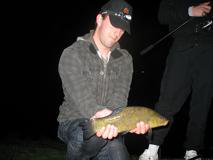

In [9]:
img = PIL.Image.open(img_file_name)
img

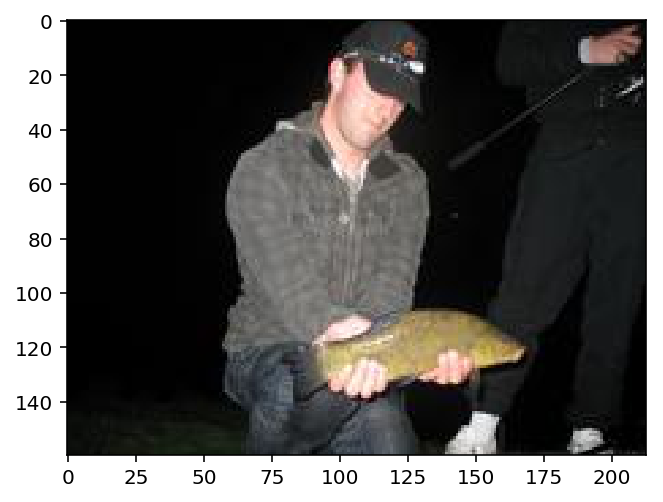

In [10]:
plt.imshow(img);

Here's the actual numerical values contained in the first 10 rows and columns of the image's first channel:

In [11]:
import numpy
imga = numpy.array(img)
imga.shape

(160, 213, 3)

In [12]:
imga[:10, :10, 0]

array([[1, 1, 1, 1, ..., 1, 1, 1, 1],
       [1, 1, 1, 1, ..., 1, 1, 1, 1],
       [1, 1, 1, 1, ..., 1, 1, 1, 1],
       [1, 1, 1, 1, ..., 1, 1, 1, 1],
       ...,
       [1, 1, 1, 1, ..., 1, 1, 1, 1],
       [1, 1, 1, 1, ..., 1, 1, 1, 1],
       [1, 1, 1, 1, ..., 1, 1, 1, 1],
       [1, 1, 1, 1, ..., 1, 1, 1, 1]], dtype=uint8)

There may be times when the directories containing images also contain other files, such as models or text files, that we don't want to read. To ensure that we don't ever try and feed non-images into our dataloaders, let's build a set of known image file extensions. We'll then be able to exclude any stray items inside image directories that we don't want to accidentally feed into our model.

In [13]:
#export 
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [14]:
' '.join(image_extensions)

'.ico .tiff .gif .pnm .jpg .pgm .ras .tif .xbm .svg .rgb .bmp .jpe .ief .xpm .xwd .jpeg .pbm .ppm .png'

Next, we create a convenience method that can either receive an input of an individual item such as a string or integer, or instead receive a list input, and convert either into a set.

In [15]:
#export
def setify(o): 
    return o if isinstance(o, set) else set(listify(o))

In [16]:
# Test that setify() does what's intended:
test_eq(setify('aa'), {'aa'})
test_eq(setify(['aa', 1]), {'aa', 1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

We need a way to automatically go through each folder in the Imagenette directory, and generate a list that contains the path of each image in the dataset. 

We'll first try to create a private function that's able to return a list containing the file paths of all images in a folder. Next we'll make the public function that can recursively execute this private function, for all folders inside the Imagenette directory.

In [17]:
#export
def _get_file_paths(path, files, extensions=None):
    path = Path(path)
    result = [path/file for file in files if not file.startswith('.')
              and ((f'.{file.split(".")[-1].lower()}' in extensions)
                   or (not extensions))]
    return result
                   
def get_file_paths(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        results = []
        for i, (path, dirnames, filenames) in enumerate(os.walk(path)):
            if include is not None and i==0:
                dirnames[:] = [o for o in dirnames if o in include]
            else:
                dirnames[:] = [o for o in dirnames if not o.startswith('.')]
            results += _get_file_paths(path, filenames, extensions)
        return results
    else:
        files = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_file_paths(path, files, extensions)

Let's test our methods out:

In [18]:
path_tench_val

PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764')

In [19]:
t = [o.name for o in os.scandir(path_tench_val)]
t = _get_file_paths(path_tench_val, t, image_extensions)
t[:3]

[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017995.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00009379.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00003014.JPEG')]

In [20]:
get_file_paths(path_tench_val, image_extensions)[:3]

[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017995.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00009379.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00003014.JPEG')]

Since all the images are in folders two directories below the root Imagenette `path`, we need to set `recurse=True`.

In [21]:
path

PosixPath('/home/ubuntu/.fastai/data/imagenette-160')

In [22]:
all_filenames = get_file_paths(path, image_extensions, recurse=True)
print(len(all_filenames))
all_filenames[:3]

13394


[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00016387.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00034544.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00009593.JPEG')]

ImageNet is 100 times larger than Imagenette, so we should verify that the above method run fast enough such that we could use them with data directly from ImageNet, should we so desire.

In [23]:
%timeit -n 10 get_file_paths(path, image_extensions, recurse=True)

74.2 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now that we know we can recurse through all folders inside the Imagenette `path` and get a list that contains paths to each image in each of the ten categories, inside both the `val` and `train` folders, it's time to create a class that can retrieve and store this list. We'll also need our class to be able to open images.

Since we may eventually want to handle a variety of datasets besides just images such as tabular or language data, it makes sense to create as flexible an architecture as possible.

To this end, we'll first create a generalized `ItemList` class, which will be able to build a list of items in a dataset, and return items from the dataset, regardless of what type of data we have.

We'll then create an `ImageList` that inherits from `ItemList` and carries out the operations specific to managing image datasets, such as using [Pillow](https://pillow.readthedocs.io/en/stable/index.html) to open an image, and making sure to only retrieve files that have an image extension.

#### `ItemList` and `ImageList` classes

In [24]:
#export

# Takes a list of transform functions and applies them, in 
# order, to an item in the dataset.
def apply_transforms(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for func in sorted(listify(funcs), key=key): 
        x = func(x, **kwargs)
    return x

class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path, self.tfms = Path(path), tfms
        
    def __repr__(self): 
        return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: cls = self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def get(self, i): return i
    
    def _get(self, i): return apply_transforms(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        result = super().__getitem__(idx)
        if isinstance(result, list): 
            return [self._get(o) for o in result]
        return self._get(result)
    
class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_file_paths(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, file_name):
        return PIL.Image.open(file_name)

<a id='step_two'></a>
### 2. Applying Image Preprocessing Transforms

We usually think of image transforms in the context generating training image data augmentation. However, there may often be several transforms that will also need to be applied as part of the preprocessing pipeline. 

For example, our `ImageList` class returns raw PIL images. In order to train our model, we'll need to convert these images to RGB format.

At the bare minimum, transforms can be simple functions that we pass to an `ImageList()` object. However, order of operations often matters when we need to apply a string of transforms to items in a dataset. To accommodate this, we can create a `Transform` class with an `_order` attribute. We can then create a class for each individual transform that inherits from `Transform` and specifies its order amongst all other transforms.

#### Transform images to RGB format

In [25]:
#export
class Transform():
    _order = 0
    
# No need to specify _order attribute for MakeRGB.
# We want to use default value of 0.
class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')

#### Resize image transform
While we're it, now is also a good time to write the logic to resize our images into a format (square aspect ratio, and if we're using a ResNet, with a height/width that is a multiple if 8) that's compatible with our CNN.

Pillow makes it easy for us to resize our images, and for now we'll go ahead and use it. Note, however, that there are much faster ways to resize in parallel, images that are stored as byte tensors on the GPU. We learn about how to do image resizing on the GPU in [notebook 10](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/10_augmentation_my_reimplementation.ipynb?flush_cache=true), when we cover image augmentation in detail.

In [26]:
#export
class ResizeFixed(Transform):
    _order = 10
    def __init__(self, size):
        if isinstance(size, int): size = (size, size)
        self.size = size
        
    def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)

#### Byte and float tensor transforms
in order to train a neural network, we have to ensure that our data is formatted into the tensor objects that PyTorch expects. After resizing images, we'll need to convert them first to byte tensors, and then to float tensors. Each of these operations is quite simple and doesn't warrant the creation of a class. This is a good opportunity to demonstrate that simple functions can be transforms, as well.

In [27]:
#export
def to_byte_tensor(item):
    result = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w, h = item.size
    return result.view(h,w,-1).permute(2,0,1)

# Set order to ensure we convert to byte tensor 
# after resizing.
to_byte_tensor._order=20

def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order=30

Now we can create an `ImageList()` object that contains paths to all images in the dataset, and also keeps track of all preprocessing transforms and the order in which they should be applied, in only one line of code!

In [28]:
tfms = [MakeRGB(), ResizeFixed(128), to_byte_tensor, to_float_tensor]
image_list = ImageList.from_files(path, tfms=tfms)
image_list

ImageList (13394 items)
[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00016387.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00034544.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00009593.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00029149.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00037770.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00009370.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00031268.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00047147.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00031035.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00020698.JPE

### 3. Splitting off the validation set

Remember that the top-level Imagenette folder contains two subfolders `train` and `val`, and each of these two folders contains ten folders for each of the ten image classes.

While we have collected file paths to *all* images in both the `train` and `val` folders, we still need a way to tell our model that the training images for the ten classes reside in `train` and the validation set images reside in `val`.

Conveniently, the fact that we've stored each image's file name as a `path` object means we can access the name of the grandparent folder of any of our images, in order to determine whether it belongs in the training or validation set.

For example:

In [29]:
file_name = image_list.items[0]
file_name

PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00016387.JPEG')

In [30]:
file_name.parent.parent.name

'val'

Our splitter will have two components. The first is a private `_split_by_function()` method which takes both a list of items and another function as inputs. This method will use the function passed to it to process each item according to a certain criteria and then add the item to one of two lists that will be returned as outputs. 

Since we're splitting by the name of each image's grandparent folder (`train` or `val`), our splitter's second component will be the function that gets passed to `_split_by_function()`, whose job is to view each image's grandparent folder and decide if it says "train" or "val."

In [31]:
#export
def _split_by_function(items, func):
    mask = [func(o) for o in items]
    # `None` values are filtered out
    falses = [o for o, m in zip(items, mask) if m==False]
    trues  = [o for o, m in zip(items, mask) if m==True]
    return falses, trues

def grandparent_splitter(filename, valid_name='valid', train_name='train'):
    grandparent = filename.parent.parent.name
    return True if grandparent==valid_name else False if grandparent==train_name else None

In [32]:
splitter = partial(grandparent_splitter, valid_name='val')

In [33]:
%time train, valid = _split_by_function(image_list, splitter)

CPU times: user 38.5 ms, sys: 157 µs, total: 38.6 ms
Wall time: 38.2 ms


In [34]:
train[0:3]

[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_9403.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_6402.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_4446.JPEG')]

In [35]:
valid[0:3]

[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00016387.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00034544.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00009593.JPEG')]

In [36]:
len(train), len(valid)

(12894, 500)

So we've verified that we know how to split our dataset into train and validation cohorts. However, to make things easy to manage, we should create a class that can both execute the initial split, as well as store both the lists containing the file paths for the train and validation sets.

In [37]:
#export
class SplitData():
    def __init__(self, train, valid):
        self.train, self.valid = train, valid
    
    def __getattr__(self, k): return getattr(self.train, k)
    
    # This method necessary if we ever want to pickle this 
    # SplitData class and load it without any recursion errors.
    def __setstate__(self, data:Any): 
        self.__dict__.update(data)
        
    @classmethod
    def split_by_function(cls, image_list, func):
        lists = map(image_list.new, _split_by_function(image_list.items, func))
        return cls(*lists)
    
    def __repr__(self): 
        return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

# Convenience wrapper function that can take a ImageList() object
# and returns a SplitData() object that has split the dataset 
# according to the information provided by the function that's 
# passed via the 'func' parameter.
def split_by_function(image_list_object, func):
    return SplitData.split_by_function(image_list_object, func)

In [38]:
splitter = partial(grandparent_splitter, valid_name='val')

In [39]:
split_data = split_by_function(image_list, splitter)
split_data

SplitData
Train: ImageList (12894 items)
[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_9403.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_6402.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_4446.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_22655.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_29390.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_17004.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_8837.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_19451.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_12883.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_13476.JPEG')...]
Path: /home/ubuntu/.fastai/data/imagene

### 4.  Labeling

In [step 2.](#step_two) above, we wrote a class to apply an RGB transform to each raw Pillow image. This was an example of a transform that wouldn't be used for training data augmentation, but to preprocess the entire dataset. Notably, it was a transform that needed to be applied to every image in the dataset, regardless of whether or not it would ultimately end up inside the training or validation set. A similar kind of preprocessing common in computer vision pipelines is image resizing.

Right now we'll take a look at other kinds of data preprocessing that are still performed before model training, but must take place *after* the validation set is split off. The hallmark of these kinds of transforms is that they first compute some state using the training set, and then apply this state, without any modification, to the validation set.

Here are some examples from various domains:
* Language data: **tokenizing** and **numericalizing** training text data, and then numericalizing the validation set using the same vocabulary as the training set.
* Tabular data: **imputing missing values** of features with the median value of each feature, computed using the training set's data. These median values will then be used to fill any missing values in corresponding features inside the validation set.
* Image data: **converting label strings to numbers**, ensuring that a consistent mapping is used on both the training and validation samples.

It so happens that in our imageset, we have images that are stored in folders that have names like `n03888257`, which itself happens to correspond to the parachute class. In order for our model to function properly, we need to convert each of these ten unique, "serial number" style labels (of our ten classes) into unique integer index values in the range [0,9]. This is because our model's softmax layer will generate prediction logits for ten categories, and we need to ensure that the right logit is generated for the right category. 

In order to carry out this label-to-index mapping, we will use a *Processor*, which is a transformation that is applied only once at initialization, to all inputs at the same time.

Below we'll walk through steps where we define a set of classes we'll use to:
1. Curate a vocabulary based on the training set's labels and map each label to a unique integer in the range [0,9].
2. Compile a list of these integer labels that correspond to each item in the training set.
3. Do the same for the validation set.

In [40]:
#export
from collections import OrderedDict

# Helper method to return a list of unique values
def uniqueify(x, sort=False):
    result = list(OrderedDict.fromkeys(x).keys())
    if sort: result.sort()
    return result

# General class for all Processors
class Processor():
    def process(self, items): return items
    
# Processor class to convert categories to unique integer indices
class CategoryProcessor(Processor):
    def __init__(self): self.vocab=None
        
    def __call__(self, items):
        # Category "vocab" defined on first use
        if self.vocab is None:
            self.vocab = uniqueify(items)
            # Create mapping of each class to an index
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [self.process_one_item(o) for o in items]
    
    # Get the index corresponding to a class label
    def process_one_item(self, item): return self.otoi[item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deprocess_one_item(idx) for idx in idxs]
    
    # Get the class label corresponding to one index
    def deprocess_one_item(self, idx): return self.vocab[idx]

In the `CategoryProcessor` class we now have logic that we can use to map unique index values to each label in the training set. We can also use this class to give us the label that corresponds to an index, or the index that corresponds to a label, for any item in our dataset.

Now we need a way to manage the process of generating a label-to-index mapping based on the training set, applying this mapping to both the training and validation set, in order to create and then store lists of numerical labels for all items in each set.

In [41]:
#export

# The parent directory of each Imagenette image file's path 
# contains the class label. This helper method returns 
# that label for us.
def parent_labeler(filename): return filename.parent.name

# Private method which will be used to apply the above 
# parent_labeler function to each item in the dataset.
# Will generate an ItemList containing the class label of
# of each item.
def _label_by_function(dataset, func, cls=ItemList): 
    return cls([func(o) for o in dataset.items], path=dataset.path)

class LabeledData():
    def process(self, imagelist, processor):
        return imagelist.new(apply_transforms(imagelist.items, processor))
    
    def __init__(self, x, y, x_processor=None, y_processor=None):
        self.x, self.y = self.process(x, x_processor), self.process(y, y_processor)
        self.x_processor, self.y_processor = x_processor, y_processor
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    
    def __getitem__(self, idx): return self.x[idx], self.y[idx]
    
    def __len__(self): return len(self.x)
    
    # Get the actual image object of any item in dataset
    def x_obj(self, idx): return self.obj(self.x, idx, self.x_processor)
    
    # Get the actual class label of any item in dataset
    def y_obj(self, idx): return self.obj(self.y, idx, self.y_processor)
    
    def obj(self, items, idx, processors):
        isint = isinstance(idx, int) or (isinstance(idx, torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for processor in reversed(listify(processors)):
            item = processor.deprocess_one_item(item) if isint else processor.deprocess(item)
        return item
    
    @classmethod
    def label_by_function(cls, imagelist, func, x_processor=None, y_processor=None):
        return cls(imagelist, _label_by_function(imagelist, func), x_processor=x_processor, y_processor=y_processor)

# Convenience wrapper function that can take a SplitData() object
# and apply a processor to its train and valid sets. The 
# processor labels according to the info provided by a labeler 
# function (func).
def label_by_function(split_data_object, func, x_processor=None, y_processor=None):
    train = LabeledData.label_by_function(split_data_object.train, func, x_processor=x_processor, y_processor=y_processor)
    valid = LabeledData.label_by_function(split_data_object.valid, func, x_processor=x_processor, y_processor=y_processor)
    return SplitData(train, valid)

The above `label_by_function` convenience wrapper method returns a `SplitData()` object that contains: 
* `LabeledData()` object that holds the labels for the train set.
* A second `LabeledData()` object containing the validation set's labels. 

The `parent_labeler` method grabs the class name (e.g. `n03888257`) for any item in the dataset. The `label_by_function` classmethod inside the `LabeledData` class uses `parent_labeler` to get a list of labels for a list of items, say the train or validation set, and then constructs a `LabeledData()` object. 

At this point, `LabeledData` uses a `CategoryProcessor()` object to either create a vocabulary of class labels and a numerical index mapping (only if this is the first time the `CategoryProcessor()` object is being called), as well as to then apply the mapping to create a list of numerical index labels for the train or valid set. Since we want to create a vocabulary based on the train set, we call `LabeledData.label_by_function()` *first on the training data*. Only after that do we call it using the validation data. This ensures that the vocabulary created the first time the particular `CategoryProcessor()` object is called is also applied used to generate the validation sets numerical labels.

The moral of the story is that taking the time create the `CategoryProcessor` and `LabeledData` classes, in addition to the several helper methods, enables us to generate a label lists for our dataset's train and validation sets in just one line of code:

In [42]:
label_list = label_by_function(split_data, parent_labeler, y_processor=CategoryProcessor())
label_list

SplitData
Train: LabeledData
x: ImageList (12894 items)
[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_9403.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_6402.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_4446.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_22655.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_29390.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_17004.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_8837.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_19451.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_12883.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_13476.JPEG')...]
Path: /home/ubuntu/.fast

In [43]:
assert label_list.train.y_processor is label_list.valid.y_processor

`label_list.train` and `label_list.valid` contain lists of tuples, where the first element of the tuple is the image tensor and the second element is a numerical label:

In [44]:
label_list.train[0]

(tensor([[[0.4000, 0.4078, 0.4235,  ..., 0.4824, 0.5608, 0.6314],
          [0.4000, 0.4078, 0.4157,  ..., 0.4980, 0.5373, 0.5098],
          [0.4039, 0.4157, 0.4118,  ..., 0.5020, 0.5098, 0.4471],
          ...,
          [0.1490, 0.1608, 0.1176,  ..., 0.2824, 0.2784, 0.2824],
          [0.1020, 0.1294, 0.0863,  ..., 0.2392, 0.1882, 0.2314],
          [0.0627, 0.1255, 0.1098,  ..., 0.3216, 0.2588, 0.2745]],
 
         [[0.4392, 0.4471, 0.4627,  ..., 0.4941, 0.5608, 0.6235],
          [0.4392, 0.4471, 0.4588,  ..., 0.5176, 0.5490, 0.5216],
          [0.4431, 0.4549, 0.4549,  ..., 0.5451, 0.5451, 0.4784],
          ...,
          [0.1529, 0.1686, 0.1294,  ..., 0.2314, 0.2275, 0.2314],
          [0.0902, 0.1216, 0.0863,  ..., 0.1882, 0.1373, 0.1804],
          [0.0431, 0.1098, 0.1020,  ..., 0.2706, 0.2157, 0.2314]],
 
         [[0.6510, 0.6588, 0.6745,  ..., 0.6902, 0.7569, 0.8078],
          [0.6510, 0.6627, 0.6745,  ..., 0.7451, 0.7765, 0.7373],
          [0.6667, 0.6784, 0.6784,  ...,

Here's the numerical labels for both train and validation sets:

In [45]:
label_list.train.y, label_list.valid.y

(ItemList (12894 items)
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
 Path: /home/ubuntu/.fastai/data/imagenette-160, ItemList (500 items)
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
 Path: /home/ubuntu/.fastai/data/imagenette-160)

We can access file path or the actual image tensor of any item in our train or validation sets:

In [46]:
label_list.train.x.items[0]

PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_9403.JPEG')

In [47]:
label_list.train.x_obj(0)

tensor([[[0.4000, 0.4078, 0.4235,  ..., 0.4824, 0.5608, 0.6314],
         [0.4000, 0.4078, 0.4157,  ..., 0.4980, 0.5373, 0.5098],
         [0.4039, 0.4157, 0.4118,  ..., 0.5020, 0.5098, 0.4471],
         ...,
         [0.1490, 0.1608, 0.1176,  ..., 0.2824, 0.2784, 0.2824],
         [0.1020, 0.1294, 0.0863,  ..., 0.2392, 0.1882, 0.2314],
         [0.0627, 0.1255, 0.1098,  ..., 0.3216, 0.2588, 0.2745]],

        [[0.4392, 0.4471, 0.4627,  ..., 0.4941, 0.5608, 0.6235],
         [0.4392, 0.4471, 0.4588,  ..., 0.5176, 0.5490, 0.5216],
         [0.4431, 0.4549, 0.4549,  ..., 0.5451, 0.5451, 0.4784],
         ...,
         [0.1529, 0.1686, 0.1294,  ..., 0.2314, 0.2275, 0.2314],
         [0.0902, 0.1216, 0.0863,  ..., 0.1882, 0.1373, 0.1804],
         [0.0431, 0.1098, 0.1020,  ..., 0.2706, 0.2157, 0.2314]],

        [[0.6510, 0.6588, 0.6745,  ..., 0.6902, 0.7569, 0.8078],
         [0.6510, 0.6627, 0.6745,  ..., 0.7451, 0.7765, 0.7373],
         [0.6667, 0.6784, 0.6784,  ..., 0.7961, 0.7961, 0.

The same goes for viewing any item's numerical or original class label:

In [48]:
label_list.train.y.items[0]

0

In [49]:
label_list.train.y_obj(0)

'n03888257'

Here is useful convenience method to take any tensor and display it as an image:

In [50]:
#export
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))

In [51]:
x, y = label_list.train[0]
x.shape

torch.Size([3, 128, 128])

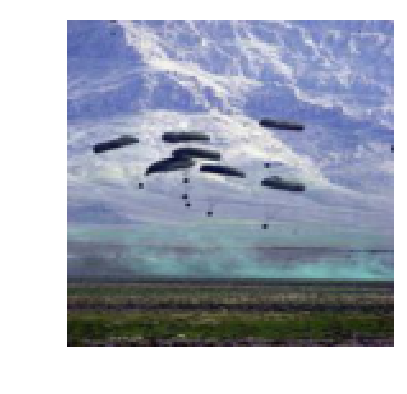

In [52]:
show_image(x)

### 5. Preparing the dataloaders

We're on the home stretch, and the only thing left to do is put our images inside dataloaders that can yield mini-batches. Here is how we've been doing it in our notebooks up until now:

In [53]:
bs=64
train_dl, valid_dl = get_dls(label_list.train, label_list.valid, bs, num_workers=4)

However, to keep with the spirit of the data block API, what we really want is a method we can chain directly to the `SplitData` object that at this point contains the train and validation images and label lists.

This will be pretty easy to accomplish. All we need to do is define a function under the `SplitData` class that creates and returns the `DataBunch()` object that contains our data loaders.

Right before we do that, we will re-implement our `DataBunch` class and give it a few upgrades. Namely, instead of just having a `channels` attribute, we'll now give it `channels_in` and `channels_out` attributes. Later on we'll see why this is a crucial tweak.

In [54]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, channels_in=None, channels_out=None):
        self.train_dl, self.valid_dl = train_dl, valid_dl
        self.channels_in, self.channels_out = channels_in, channels_out
        
    @property
    def train_ds(self): return self.train_dl.dataset
    
    @property
    def valid_ds(self): return self.valid_dl.dataset

As promised, here we define a method that can construct a `DataBunch()` object. We also wire this method into the `SplitData` class:

In [55]:
#export
def databunchify(split_data_object, bs, channels_in=None, channels_out=None, **kwargs):
    dataloaders = get_dls(split_data_object.train, split_data_object.valid, bs, **kwargs)
    return DataBunch(*dataloaders, channels_in=channels_in, channels_out=channels_out)

SplitData.to_databunch = databunchify

Recall that earlier we defined `split_by_function()` and `label_by_function()` wrapper functions that sat outside of the `SplitData` and `LabeledData` classes, respectively. We can now wire `split_by_function()` into the `ImageList` class and `label_by_function()` into the `SplitData` class, similar to how we wired `databunchify()` into the `SplitData` class just above. This will allow us to chain all the operations necessary to build the datablock, together in one line of code!

In [82]:
#export
ImageList.to_split = split_by_function
SplitData.to_label = label_by_function

### Executing the Data Block

Now we've engineered all the pieces necessary for us to take a dataset and execute the steps necessary to prepare it for model training, from initial download onward, in an *extremely concise* syntax.

Here's all it takes:

In [57]:
path = datasets.untar_data(imagenette_url)
tfms = [MakeRGB(), ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=64

data = (ImageList.from_files(path, tfms=tfms)
        .to_split(partial(grandparent_splitter, valid_name='val'))
        .to_label(parent_labeler, y_processor=CategoryProcessor())
        .to_databunch(bs, channels_in=3, channels_out=10, num_workers=4))

### Building the Model

In [58]:
callback_funcs = [partial(AvgStatsCallback, accuracy), CudaCallback]

We now need to normalize our dataset, by channel. We'll do this using the channel means and standard deviations from one batch:

In [59]:
x_batch, y_batch = next(iter(data.train_dl))
x_batch.shape

torch.Size([64, 3, 128, 128])

'n03028079'

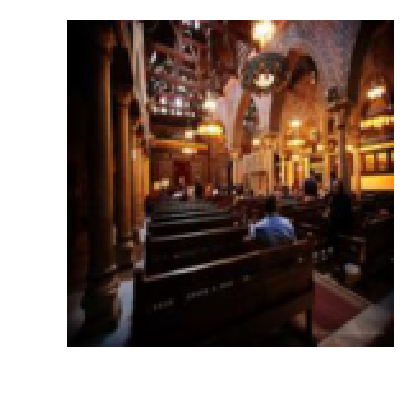

In [60]:
show_image(x_batch[0])
label_list.train.y_processor.vocab[y_batch[0]]

In [61]:
means, std_devs = x_batch.mean((0,2,3)).cuda(), x_batch.std((0,2,3)).cuda()
means, std_devs

(tensor([0.4879, 0.4740, 0.4307], device='cuda:0'),
 tensor([0.2814, 0.2831, 0.3079], device='cuda:0'))

Let's create a `norm_imagenette` callback that will use the channel-wise mean/standard deviation statistics we computed from the batch above to normalize any batch of image inputs from the Imagenette dataset:

In [72]:
#export
def normalize_channels(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

_means = tensor([0.4879, 0.4740, 0.4307])
_std_devs = tensor([0.2814, 0.2831, 0.3079])

norm_imagenette = partial(normalize_channels, mean=_means.cuda(), std=_std_devs.cuda())

In [73]:
callback_funcs.append(partial(BatchTransformXCallback, norm_imagenette))

We'll take inspiration from some of the techniques recommended in [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/abs/1812.01187) to construct our CNN.

Specifically, we don't start out by using a conv layer with 7x7 filter size, and instead use layers with a 3x3 filter size. We also don't jump from 3 input channels to 64 channels, but instead more gradually work our way up: 
1. The helper function `prev_pow_2()` is used to get the power of 2 that is closest to, but still less than, the product of: the number of input channels (3) and the square of the first layer's kernel size (3 * 3). This product will be the number of output channels of the first conv layer.
2. The second and third conv layers will each increase the number of output channels by a factor of 2, relative to the number of output channels in the previous layer.
3. At this point, the 3rd conv layer will have 64 output channels.
4. The 4th conv layer will have 64 input and output channels.
5. We then add 4 more conv layers, with output channel sizes of 64, 64, 128, and 256, respectively.
6. Finally, we add an adaptive average pooling layer and then flatten before the final fully-connected output layer.

In [74]:
# Number of output channels of each layer in our CNN
n_outs = [64, 64, 128, 256] 

In [75]:
#export
import math

def prev_pow_2(x): return 2**math.floor(math.log2(x))

def get_cnn_layers(data, n_outs, layer, **kwargs):
    
    def build_layer(n_in, n_out, stride=2):
        return layer(n_in, n_out, ks=3, stride=stride, **kwargs)
    
    L1 = data.channels_in
    L2 = prev_pow_2(L1 * 3 * 3)
    layers = [build_layer(L1  , L2  , stride=1),
              build_layer(L2  , L2*2, stride=2),
              build_layer(L2*2, L2*4, stride=2)]
    n_outs = [L2*4] + n_outs
    layers += [build_layer(n_outs[i], n_outs[i+1]) for i in range(len(n_outs) - 1)]
    layers += [nn.AdaptiveAvgPool2d(1),
               Lambda(flatten),
               nn.Linear(n_outs[-1], data.channels_out)]
    return layers

def get_cnn_model(data, n_outs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, n_outs, layer, **kwargs))

def get_learn_run(n_outs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, n_outs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We'll use the 1-cycle learning rate policy.

In [76]:
sched = combine_scheds([0.3, 0.7], cos_1cycle_anneal(0.1, 0.3, 0.05))

In [77]:
learn, run = get_learn_run(n_outs, data, 0.2, conv_layer, cbs=callback_funcs + [
    partial(ParamScheduler, 'lr', sched)
])

We can use hooks to create a `model_summary()` method that takes `Runner()`, `Learner()`, and `DataBunch()` objects as inputs and prints out each layer in our network as well as the output tensor size at each layer. This is helpful for making sure that the model that got compiled is in line with what we intended.

In [78]:
#export
def model_summary(run, learn, data, find_all=False):
    xb, yb = get_batch(data.valid_dl, run)
    device = next(learn.model.parameters()).device
    xb, yb = xb.to(device), yb.to(device)
    modules = find_modules(learn.model, is_lin_layer) if find_all else learn.model.children()
    f = lambda hook, module, inp, outp: print(f"{module}\n{outp.shape}\n")
    with ForwardHooks(modules, f) as hooks: learn.model(xb)

In [79]:
model_summary(run, learn, data)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 16, 128, 128])

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 32, 64, 64])

Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 32, 32])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 16, 16])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(

### Training the Model

In [80]:
%time run.fit(5, learn)

train: [1.7470168416511556, tensor(0.3942, device='cuda:0')]
valid: [1.557879150390625, tensor(0.4520, device='cuda:0')]
train: [1.2988105538428727, tensor(0.5698, device='cuda:0')]
valid: [1.2438936767578126, tensor(0.6020, device='cuda:0')]
train: [0.9953740141974949, tensor(0.6712, device='cuda:0')]
valid: [1.108082763671875, tensor(0.6540, device='cuda:0')]
train: [0.7420095162963394, tensor(0.7592, device='cuda:0')]
valid: [0.9234345092773437, tensor(0.7140, device='cuda:0')]
train: [0.5397424734857298, tensor(0.8318, device='cuda:0')]
valid: [0.8799122924804688, tensor(0.7320, device='cuda:0')]
CPU times: user 42.7 s, sys: 17.6 s, total: 1min
Wall time: 1min 4s


As of the date this notebook was originally created (May 4th, 2019), the [Imagenette Leaderboard](https://github.com/fastai/imagenette/blob/master/README.md)'s top validation accuracy score for 5 epochs of training on images of size 128px was `84.6%`. We can be confident that with a validation score here of `73.2%`, we're on the right track!

(The entry on the leaderboard used [mixup](https://arxiv.org/abs/1710.09412) data augmentation, which we have not covered yet!)

![Imagenette Leaderboard](images/imagenette_leaderboard.png)

### Export

In [84]:
nb_auto_export()

<IPython.core.display.Javascript object>